# 🍎 Fresh vs Rotten Fruit Classification Model

This notebook builds a deep learning model using **EfficientNetV2B1** to classify fruits as fresh or rotten. The model can identify 6 classes:
- Fresh apples, bananas, oranges
- Rotten apples, bananas, oranges

## 📊 Dataset Overview
- **Training samples**: 10,901 images
- **Validation samples**: 2,698 images
- **Classes**: 6 (3 fruit types × 2 conditions)

## 🔧 Model Architecture
- **Base Model**: EfficientNetV2B1 (pre-trained on ImageNet)
- **Input Size**: 240×240×3
- **Training Strategy**: Transfer learning with fine-tuning

## 📁 Dataset Setup

First, we'll download the fruits dataset from Kaggle and set up the directory structure.

In [1]:
# KaggleHub Dataset Download and Initial File Inspection
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("sriramr/fruits-fresh-and-rotten-for-classification")
print("Path to dataset files:", path)

os.system("rm -rf /root/.cache/kagglehub/datasets/sriramr/fruits-fresh-and-rotten-for-classification/versions/1/dataset/dataset")
os.system("find /root/.cache/kagglehub/datasets/sriramr/fruits-fresh-and-rotten-for-classification/versions/1/dataset -type f | sed 's|/[^/]*$||' | sort | uniq -c")

# It's good practice to ensure the path from kagglehub is used directly
dataset_base_path = os.path.join(path, 'dataset') # Assuming 'dataset' is the subfolder after version
TRAIN_DIR = os.path.join(dataset_base_path, 'train')
TEST_DIR = os.path.join(dataset_base_path, 'test')

print(f"TRAIN_DIR: {TRAIN_DIR}")
print(f"TEST_DIR: {TEST_DIR}")

# Verify directories exist (optional but good for debugging)
if not os.path.exists(TRAIN_DIR):
    print(f"ERROR: TRAIN_DIR does not exist: {TRAIN_DIR}")
if not os.path.exists(TEST_DIR):
    print(f"ERROR: TEST_DIR does not exist: {TEST_DIR}")

100%|██████████| 3.58G/3.58G [00:33<00:00, 116MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/sriramr/fruits-fresh-and-rotten-for-classification/versions/1
TRAIN_DIR: /root/.cache/kagglehub/datasets/sriramr/fruits-fresh-and-rotten-for-classification/versions/1/dataset/train
TEST_DIR: /root/.cache/kagglehub/datasets/sriramr/fruits-fresh-and-rotten-for-classification/versions/1/dataset/test


## 📚 Import Libraries

Loading the necessary libraries for deep learning and model building.

In [2]:
import tensorflow as tf
from tensorflow import keras

## ⚙️ Model Configuration

Setting up the hyperparameters and dataset specifications for our model.

In [3]:
IMG_SIZE = (240, 240)
BATCH_SIZE = 32
NUM_CLASSES = 6

NUM_TRAIN_SAMPLES = 10901
NUM_VALID_SAMPLES = 2698

STEPS_PER_EPOCH = NUM_TRAIN_SAMPLES // BATCH_SIZE
VALIDATION_STEPS = NUM_VALID_SAMPLES // BATCH_SIZE

## 🗂️ Data Loading

Loading and preprocessing the image datasets from the directory structure.

In [4]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    labels='inferred',
    label_mode='categorical',
    image_size=IMG_SIZE,
    interpolation='bilinear',
    batch_size=BATCH_SIZE,
    shuffle=True
)

valid_dataset = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    labels='inferred',
    label_mode='categorical',
    image_size=IMG_SIZE,
    interpolation='bilinear',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 10901 files belonging to 6 classes.
Found 2698 files belonging to 6 classes.


## 🔄 Data Augmentation

Setting up data augmentation techniques to improve model generalization and prevent overfitting.

In [5]:
data_augmentation_layers = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    tf.keras.layers.RandomContrast(0.1),
], name="data_augmentation")

In [6]:
# The EfficientNetV2B1 model with include_preprocessing=True will handle rescaling.
# So, this function just applies the augmentation to the training images.

def preprocess_and_augment_train(image, label):
    image = data_augmentation_layers(image, training=True)
    return image, label

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.map(preprocess_and_augment_train, num_parallel_calls=AUTOTUNE)

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
valid_dataset = valid_dataset.prefetch(buffer_size=AUTOTUNE)

## 🏗️ Model Architecture

Building the neural network using EfficientNetV2B1 as the base model with custom classification layers.

In [ ]:
base_model = keras.applications.EfficientNetV2B1(
    weights='imagenet',
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    include_preprocessing=True
)

base_model.trainable = False

28456008/28456008 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
inputs = keras.Input(shape=IMG_SIZE + (3,))

x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.3)(x)
outputs = keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
# Block 9: Initial Model Compilation and Summary
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()]
)

model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b1 (Functional)  │ (None, 8, 8, 1280)     │     6,931,124 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,938,810 (26.47 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 6,931,124 (26.44 MB)

## 🎯 Initial Training (Transfer Learning)

Training the model with the base layers frozen to establish good feature representations.

In [ ]:
print("Starting initial training with frozen base model...")
history_initial = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=10,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS
)

Starting initial training with frozen base model...
Epoch 1/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 263s 667ms/step - categorical_accuracy: 0.8045 - loss: 0.6235 - val_categorical_accuracy: 0.9617 - val_loss: 0.1243
Epoch 2/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - categorical_accuracy: 0.9048 - loss: 0.2098 - val_categorical_accuracy: 0.9617 - val_loss: 0.1236
Epoch 3/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 263s 771ms/step - categorical_accuracy: 0.9581 - loss: 0.1458 - val_categorical_accuracy: 0.9784 - val_loss: 0.0792
Epoch 4/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - categorical_accuracy: 0.9524 - loss: 0.2216 - val_categorical_accuracy: 0.9792 - val_loss: 0.0790
Epoch 5/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 264s 624ms/step - categorical_accuracy: 0.9689 - loss: 0.1058 - val_categorical_accuracy: 0.9840 - val_loss: 0.0604
Epoch 6/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - categorical_accuracy: 1.0000 - loss: 0.0427 - val_categorical_accuracy: 0.9836 - val_loss: 0.0603
Epoch 7/10
340/340 ━

## 💾 Model Saving

Saving the initial trained model for backup and deployment purposes.

In [ ]:
model.save('InitialModelEfficient.keras')

In [ ]:
tf.saved_model.save(model, 'InitialModelEfficientTF')

In [ ]:
!zip -r InitialModelEfficient.zip InitialModelEfficient

  adding: InitialModelEfficient/ (stored 0%)
  adding: InitialModelEfficient/assets/ (stored 0%)
  adding: InitialModelEfficient/fingerprint.pb (stored 0%)
  adding: InitialModelEfficient/saved_model.pb (deflated 93%)
  adding: InitialModelEfficient/variables/ (stored 0%)
  adding: InitialModelEfficient/variables/variables.index (deflated 78%)
  adding: InitialModelEfficient/variables/variables.data-00000-of-00001 (deflated 8%)


## 📊 Initial Model Evaluation

Evaluating the performance after the initial training phase.

In [ ]:
loss_initial, acc_initial = model.evaluate(
    valid_dataset,
    steps=VALIDATION_STEPS
)


Evaluating model after initial training (frozen base):
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - categorical_accuracy: 0.9905 - loss: 0.0328
Initial validation loss: 0.0478
Initial validation accuracy: 0.9862


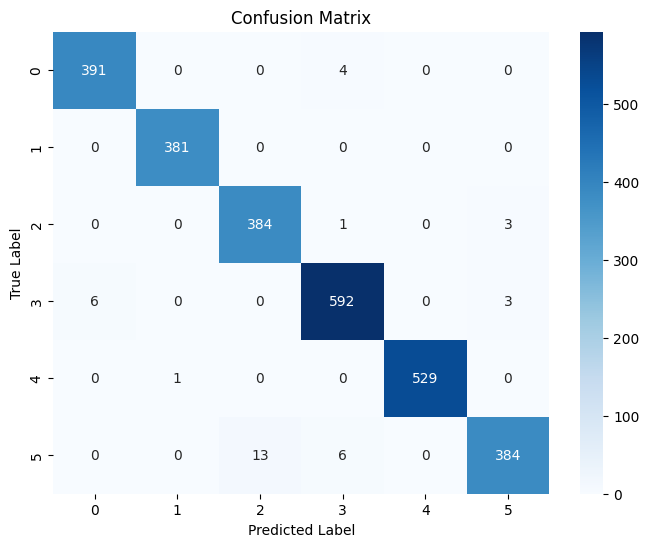

Accuracy: 0.986286137879911
Precision (weighted): 0.9863469381297978
Recall (weighted): 0.986286137879911
F1 Score (weighted): 0.9862572108670434

Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       395
           1       1.00      1.00      1.00       381
           2       0.97      0.99      0.98       388
           3       0.98      0.99      0.98       601
           4       1.00      1.00      1.00       530
           5       0.98      0.95      0.97       403

    accuracy                           0.99      2698
   macro avg       0.99      0.99      0.99      2698
weighted avg       0.99      0.99      0.99      2698



In [9]:
# 📊 Model Evaluation & Confusion Matrix

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

# 🔄 Collect all validation images and labels into tensors
all_images = []
all_labels = []

for batch_images, batch_labels in valid_dataset:
    all_images.append(batch_images)
    all_labels.append(batch_labels)

all_images = tf.concat(all_images, axis=0)
all_labels = tf.concat(all_labels, axis=0)

# 🔮 Predict all at once
y_pred_probs = model.predict(all_images, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(all_labels.numpy(), axis=1)

# 🧮 Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# 📈 Classification Metrics
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision (weighted):", precision_score(y_true, y_pred, average='weighted'))
print("Recall (weighted):", recall_score(y_true, y_pred, average='weighted'))
print("F1 Score (weighted):", f1_score(y_true, y_pred, average='weighted'))

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred))


## 🔧 Fine-Tuning

Unfreezing the base model and training with a lower learning rate to fine-tune the pre-trained weights.

In [ ]:
base_model.trainable = True

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()]
)

model.summary()

In [ ]:
print("\nStarting fine-tuning training with unfrozen base model...")
epochs_fine_tuning = 15
initial_epoch_count = history_initial.epoch[-1] + 1

history_fine_tune = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=initial_epoch_count + epochs_fine_tuning,
    initial_epoch=initial_epoch_count,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS
)

## 🎉 Final Model Evaluation

Evaluating the final model performance after fine-tuning to see the improvement.

In [ ]:
loss_final, acc_final = model.evaluate(
    valid_dataset,
    steps=VALIDATION_STEPS
)
print(f"Final validation loss: {loss_final:.4f}")
print(f"Final validation accuracy: {acc_final:.4f}")

In [ ]:
class_names = train_dataset.class_names
print("\nClass Names:", class_names)

class_indices_map = {name: i for i, name in enumerate(class_names)}
print("Class Indices Map:", class_indices_map)

print("Model Metrics Names:", model.metrics_names)

## 🚀 Model Export for Web Deployment

Converting the trained model to TensorFlow.js format for web application deployment.

In [ ]:
!rm -rf ./InitialModelEfficientjskeras

In [ ]:
!tensorflowjs_converter --input_format=tf_saved_model --weight_shard_size_bytes=30000000 ./InitialModelEfficient ./InitialModelEfficientjskeras


2025-06-02 01:19:50.601053: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748827190.629539   47118 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748827190.639752   47118 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-06-02 01:19:54.756172: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1748827194.756384   47118 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

## ✅ Summary

This notebook successfully implemented a fruit freshness classification model with the following achievements:

### 🎯 **Model Performance**
- Built using **EfficientNetV2B1** pre-trained architecture
- Achieved classification across **6 classes** (3 fruits × 2 conditions)
- Implemented **transfer learning** with fine-tuning strategy

### 🔧 **Technical Implementation**
- **Data Augmentation**: Random flips, rotations, zoom, and contrast adjustments
- **Two-phase Training**: Initial frozen training followed by fine-tuning
- **Model Export**: TensorFlow.js format for web deployment

### 📊 **Dataset**
- **Training**: 10,901 images
- **Validation**: 2,698 images
- **Classes**: Fresh/Rotten × Apples/Bananas/Oranges

The model is now ready for deployment in the CheckFresh mobile application! 🍎📱